In [1]:
# importing libraries.
import pandas as pd
import numpy as np

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import itertools

import base64

import io

Loading Data

In [2]:
# Used breeds.
breeds = ['beagle', 'bernese_mountain_dog', 'doberman', 'labrador_retriever', 'siberian_husky']
# Dictionary with parameters necessary to read img.
kwargs = {
    'labels' : 'inferred',
    'label_mode' : 'categorical',
    'batch_size' : 32,
    'image_size' : (128,128),
    'seed' : 10,
    'validation_split' : 0.3,
    'class_names' : breeds,
}
# Loading img and converting them into a tensorflow dataset
train = tf.keras.utils.image_dataset_from_directory(
    './data/images/',
    subset='training',
    **kwargs
)

test = tf.keras.utils.image_dataset_from_directory(
    './data/images/',
    subset='validation',
    **kwargs
)

Found 926 files belonging to 5 classes.
Using 649 files for training.
Found 926 files belonging to 5 classes.
Using 277 files for validation.


Exploring images in data

In [3]:
# Seeing what i have just obtained.
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [4]:
# Taking my first batch of images, a single batch has 32 images.
first_batch = train.take(1)
first_batch

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [5]:
# Calling 'list' to force the iterator to evaluate.
images, labels = list(first_batch)[0]
# Obtaining the first element in images.
first_img = images[0]
# Looking into red array, how much red is in each pixel.
first_img[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[22.641113 , 18.281616 , 26.2771   ],
       [17.80774  , 34.179565 ,  0.3590088],
       [12.177734 ,  9.972656 , 18.231812 ]], dtype=float32)>

In [6]:
# Looking into green array.
first_img[:3,:3,1]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[64.05701 , 50.55432 , 52.80835 ],
       [53.946777, 64.38965 , 21.253418],
       [43.027954, 36.875   , 43.86743 ]], dtype=float32)>

In [7]:
# Looking into blue array.
first_img[:3,:3,2]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[19.15857   , 20.081665  , 22.368164  ],
       [17.42102   , 40.73645   ,  0.28430176],
       [ 8.34314   , 13.624756  , 19.851807  ]], dtype=float32)>

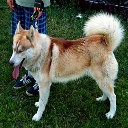

In [8]:
# Displaying the img.
# Converting Tensor to array.
first_img = np.array(first_img).astype('uint8')
Image.fromarray(first_img)

In [9]:
# Checking label corresponding to the previous img.
print(breeds)
print(labels[0])

['beagle', 'bernese_mountain_dog', 'doberman', 'labrador_retriever', 'siberian_husky']
tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


Training initial CNN.

In [10]:
# Storing img in memory, do not load from disk every time.
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# Creating first model.
first_model = keras.Sequential([
    # Base.
    layers.Rescaling(1./255),# Rescaling data because pixel intensity is from 0 to 255, neural net works better when those values are instead from 0 to 1.
    layers.Conv2D(filters=16, kernel_size=3,padding='same', activation='relu', input_shape=[128,128,3]), # Scanning img with CNN, generating new features.
    
    # Head.
    # Making predictions with the features obtained by 'Base'.
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(breeds))
])
# Compiling model, so its ready for making predictions.
first_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = first_model.fit(
    train,
    validation_data=test,
    epochs=5,
    verbose=1
)

Epoch 1/5
21/21 [==============================] - 3s 30ms/step - loss: 9.5713 - accuracy: 0.1541 - val_loss: 9.6592 - val_accuracy: 0.1877
Epoch 2/5
21/21 [==============================] - 0s 17ms/step - loss: 9.8348 - accuracy: 0.1618 - val_loss: 9.6592 - val_accuracy: 0.1877
Epoch 3/5
21/21 [==============================] - 0s 17ms/step - loss: 9.8348 - accuracy: 0.1618 - val_loss: 9.6592 - val_accuracy: 0.1877
Epoch 4/5
21/21 [==============================] - 0s 17ms/step - loss: 9.8596 - accuracy: 0.1618 - val_loss: 9.6592 - val_accuracy: 0.1877
Epoch 5/5
21/21 [==============================] - 0s 17ms/step - loss: 9.8596 - accuracy: 0.1618 - val_loss: 9.6592 - val_accuracy: 0.1877


In [12]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 128)               33554560  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 33,555,653
Trainable params: 33,555,653
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot: >

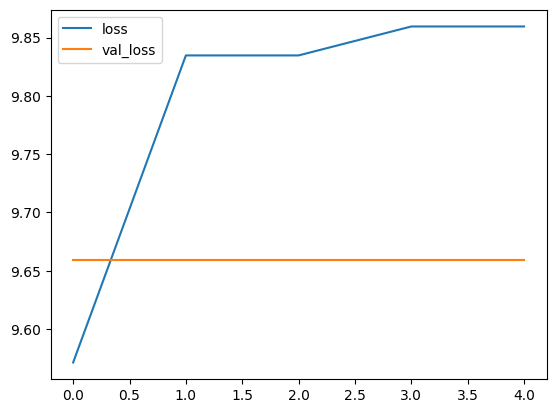

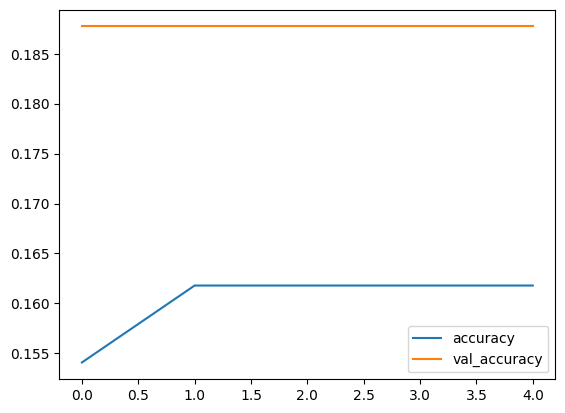

In [13]:
history_frame_1 = pd.DataFrame(history.history)

history_frame_1[['loss', 'val_loss']].plot()
history_frame_1[['accuracy', 'val_accuracy']].plot()

Improving model accuracy

In [14]:
# Function that takes network and epochs as paramers.
#   // and will train the model, returning history DF and trained model.
def train_model (network, epochs=5):
    # Early stopping.
    stop = keras.callbacks.EarlyStopping(
        min_delta=0.001,
        patience=10,
        restore_best_weights=True
    )
    
    model = keras.Sequential(network)
    
    opt = keras.optimizers.Adam()
    model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
    
    history = model.fit(
    train,
    validation_data=test,
    epochs=epochs,
    verbose=1,
    #callbacks=[stop]
    )
    
    history_frame = pd.DataFrame(history.history)
    return history_frame, model

In [15]:
data_augmentation = keras.Sequential([
    layers.RandomContrast(factor=0.5),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomRotation(factor=0.1, fill_mode='reflect'),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

network = [
    # Data Augmentation.
    data_augmentation,
    
    # Base
    layers.Rescaling(1./255),

    layers.BatchNormalization(input_shape=(128,128,3)),
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool2D(),

    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool2D(),

    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool2D(),

    layers.Dropout(.2),
    
    # Head.
    layers.Flatten(),
    
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    
    layers.Dense(len(breeds), activation='softmax')
]

history_df, model = train_model(network, epochs=50)

Epoch 1/50
21/21 [==============================] - 4s 89ms/step - loss: 1.7620 - accuracy: 0.2681 - val_loss: 1.6576 - val_accuracy: 0.1877
Epoch 2/50
21/21 [==============================] - 1s 39ms/step - loss: 1.5641 - accuracy: 0.3128 - val_loss: 1.6754 - val_accuracy: 0.1625
Epoch 3/50
21/21 [==============================] - 1s 40ms/step - loss: 1.4767 - accuracy: 0.3606 - val_loss: 1.7356 - val_accuracy: 0.1986
Epoch 4/50
21/21 [==============================] - 1s 40ms/step - loss: 1.4523 - accuracy: 0.3775 - val_loss: 1.7705 - val_accuracy: 0.2094
Epoch 5/50
21/21 [==============================] - 1s 40ms/step - loss: 1.3598 - accuracy: 0.4191 - val_loss: 1.8212 - val_accuracy: 0.2022
Epoch 6/50
21/21 [==============================] - 1s 41ms/step - loss: 1.3634 - accuracy: 0.4422 - val_loss: 1.7870 - val_accuracy: 0.1841
Epoch 7/50
21/21 [==============================] - 1s 41ms/step - loss: 1.3250 - accuracy: 0.4284 - val_loss: 1.9200 - val_accuracy: 0.1697
Epoch 8/50
21

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                    

<AxesSubplot: >

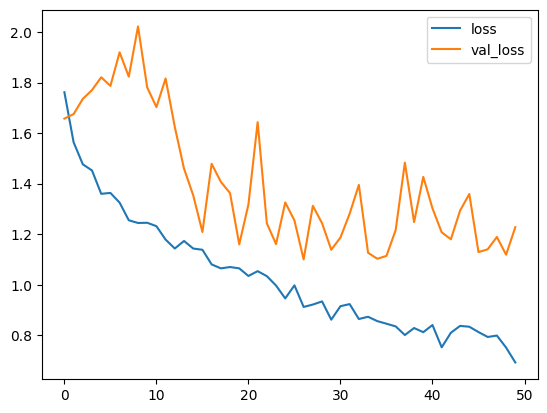

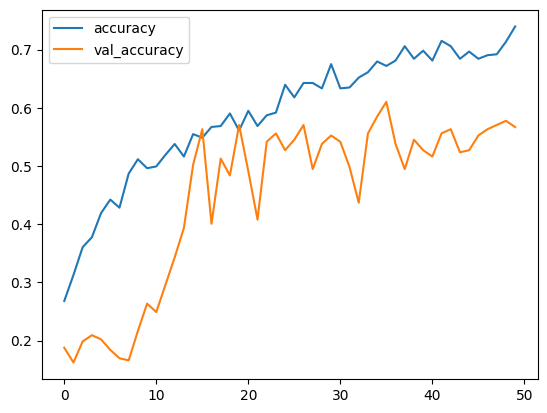

In [17]:
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

Investigating Model error.

In [18]:
# First i will generate predictions.
y_pred = model.predict(test)

# Getting predicted class.
predicted_class = np.argmax(y_pred, axis=1)
predicted_class

array([3, 1, 0, 0, 4, 1, 0, 2, 3, 3, 0, 3, 4, 3, 3, 0, 1, 2, 2, 2, 0, 0,
       1, 2, 0, 0, 4, 3, 1, 1, 4, 4, 4, 0, 3, 0, 1, 0, 4, 4, 1, 1, 3, 2,
       0, 1, 2, 1, 0, 0, 1, 0, 3, 2, 0, 0, 2, 0, 0, 2, 4, 2, 2, 0, 4, 0,
       0, 2, 4, 4, 0, 0, 0, 1, 4, 1, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0,
       0, 4, 1, 2, 0, 2, 2, 1, 0, 4, 3, 0, 0, 0, 2, 1, 2, 0, 1, 1, 1, 3,
       2, 1, 0, 0, 0, 2, 2, 1, 4, 3, 0, 2, 4, 0, 1, 0, 0, 0, 3, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 3, 2, 3, 4, 1, 0, 0, 1, 2, 2, 0, 2, 3, 3, 3, 0,
       0, 4, 1, 0, 1, 0, 0, 1, 4, 1, 1, 4, 1, 4, 4, 3, 2, 2, 0, 0, 1, 3,
       2, 0, 4, 1, 1, 0, 2, 0, 0, 4, 1, 3, 4, 4, 3, 0, 1, 0, 4, 4, 0, 2,
       0, 3, 4, 3, 2, 0, 0, 2, 1, 4, 1, 4, 4, 1, 0, 4, 4, 2, 1, 4, 4, 0,
       0, 4, 3, 1, 3, 3, 3, 4, 0, 3, 2, 2, 0, 4, 4, 3, 1, 1, 1, 2, 4, 1,
       0, 3, 0, 3, 1, 0, 3, 3, 3, 3, 0, 1, 2, 3, 1, 1, 4, 1, 4, 0, 0, 2,
       2, 0, 1, 1, 0, 0, 3, 1, 0, 1, 4, 4, 3], dtype=int64)

In [19]:
# Obtaining actual labels out of test dataset.
actual_labels = np.concatenate([y for x,y in test], axis=0)
actual_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [20]:
actual_class = np.argmax(actual_labels, axis=1)
actual_class

array([3, 3, 3, 4, 1, 3, 0, 2, 0, 0, 4, 2, 0, 3, 0, 2, 1, 3, 4, 3, 0, 0,
       1, 2, 0, 0, 3, 3, 1, 1, 4, 0, 3, 0, 4, 1, 1, 1, 4, 4, 1, 1, 1, 2,
       4, 1, 2, 1, 0, 0, 1, 2, 3, 2, 2, 2, 2, 0, 1, 4, 3, 2, 2, 0, 4, 0,
       4, 2, 4, 0, 1, 4, 1, 1, 3, 1, 0, 2, 3, 2, 0, 0, 4, 2, 0, 2, 2, 4,
       0, 4, 1, 3, 4, 2, 1, 1, 0, 4, 0, 0, 0, 4, 2, 1, 2, 0, 3, 4, 1, 1,
       2, 1, 0, 4, 3, 2, 2, 1, 4, 3, 0, 2, 3, 0, 1, 0, 0, 4, 0, 1, 1, 4,
       1, 1, 0, 1, 2, 3, 2, 4, 3, 4, 1, 3, 3, 1, 2, 2, 3, 2, 1, 3, 3, 0,
       0, 3, 1, 0, 1, 0, 0, 1, 4, 0, 1, 4, 1, 4, 4, 4, 3, 3, 3, 2, 4, 1,
       2, 2, 4, 4, 1, 3, 2, 0, 0, 4, 1, 4, 4, 4, 3, 1, 1, 1, 4, 4, 4, 2,
       0, 4, 4, 4, 3, 4, 0, 2, 4, 4, 1, 1, 4, 1, 2, 4, 4, 3, 2, 4, 4, 4,
       1, 4, 3, 1, 1, 4, 3, 4, 2, 0, 3, 4, 1, 1, 4, 3, 2, 4, 4, 2, 4, 1,
       3, 3, 4, 2, 1, 0, 0, 3, 2, 3, 0, 2, 2, 1, 1, 1, 1, 0, 4, 1, 2, 2,
       2, 4, 1, 1, 4, 4, 3, 1, 0, 2, 3, 2, 3], dtype=int64)

Text(50.5815972222222, 0.5, 'Valores Reales')

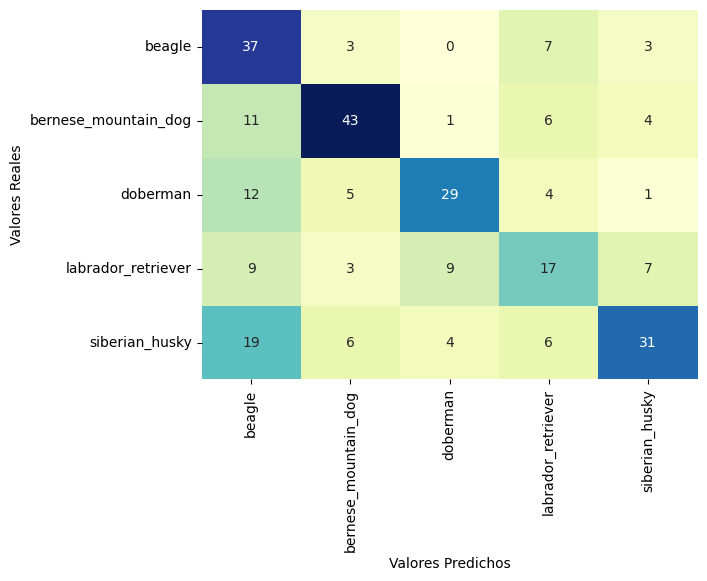

In [21]:
cm = confusion_matrix(actual_class, predicted_class)

cm_df = pd.DataFrame(
    cm,
    index=breeds,
    columns=breeds
)

sns.heatmap(cm_df, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
plt.xlabel('Valores Predichos')
plt.ylabel('Valores Reales')

Now im going to get the image out and see the real value, predicted value and the image itself. 

In [22]:
# Getting images, in order to do that ill iterate over each bach in test
#   // and get the batch ('x'), ill convert the image into an array.
actual_image = [np.array(x).astype('uint8') for x,y in test]

# Compressing into a single list, the list of lists that was just obtained
# I do this so i can obtain a list of all the images.
actual_image = list(itertools.chain.from_iterable(actual_image))

# Turning array into python img class.
actual_image = [Image.fromarray(a) for a in actual_image]

# Combining all togeter into a dataframe, using zip function
#   // to put my three arrays together.
pred_df = pd.DataFrame(
    zip(actual_class, predicted_class, actual_image),
    columns=['actual', 'prediction' , 'image']
    )
pred_df.head()

,actual,prediction,image
0,3,3,<PIL.Image.Image image mode=RGB size=128x128 a...
1,3,1,<PIL.Image.Image image mode=RGB size=128x128 a...
2,3,0,<PIL.Image.Image image mode=RGB size=128x128 a...
3,4,0,<PIL.Image.Image image mode=RGB size=128x128 a...
4,1,4,<PIL.Image.Image image mode=RGB size=128x128 a...


In [23]:
# Maping values, the values on each columns corresponds to each breed position
pred_df['actual'] = pred_df['actual'].apply(lambda x: breeds[x])
pred_df['prediction'] = pred_df['prediction'].apply(lambda x: breeds[x])

pred_df.head()

,actual,prediction,image
0,labrador_retriever,labrador_retriever,<PIL.Image.Image image mode=RGB size=128x128 a...
1,labrador_retriever,bernese_mountain_dog,<PIL.Image.Image image mode=RGB size=128x128 a...
2,labrador_retriever,beagle,<PIL.Image.Image image mode=RGB size=128x128 a...
3,siberian_husky,beagle,<PIL.Image.Image image mode=RGB size=128x128 a...
4,bernese_mountain_dog,siberian_husky,<PIL.Image.Image image mode=RGB size=128x128 a...


In [24]:
# Now im going to create a function so i can render the images in the DataFrame as html. 
def image_formatter(img):
    with io.BytesIO() as buffer:
        # writing img to a in-memory object ('buffer')
        img.save(buffer, 'png')
        # Reading img out of buffer as a string and converting it into a b64 string.
        #   // this enables me to embed it into html.
        img_str = base64.b64encode(buffer.getvalue()).decode()
        
        return f'<img src="data:image/jpeg;base64,{img_str}">'

,actual,prediction,image
211,bernese_mountain_dog,bernese_mountain_dog,
157,beagle,beagle,
184,beagle,beagle,
235,labrador_retriever,labrador_retriever,
266,bernese_mountain_dog,bernese_mountain_dog,

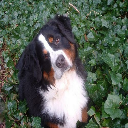
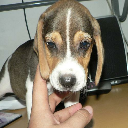
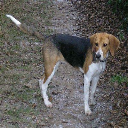
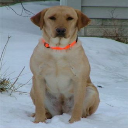
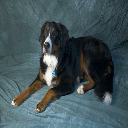

In [25]:
pred_df.sample(5).style.format({'image':image_formatter})

Checking how pretrained model VGG-16 perfoms over my CNN.

In [26]:
pretrained_base = VGG16(include_top=False, input_shape=[128,128,3])

network = [
    # Data Augmentation
    data_augmentation,
    
    # Base.
    pretrained_base,
    
    # Head.
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(breeds), activation='softmax')
]

history_df_vgg16, model_vgg16 = train_model(network, epochs= 20)

Epoch 1/20
21/21 [==============================] - 8s 241ms/step - loss: 1.9004 - accuracy: 0.2173 - val_loss: 326959.4062 - val_accuracy: 0.1697
Epoch 2/20
21/21 [==============================] - 3s 164ms/step - loss: 2.2696 - accuracy: 0.2250 - val_loss: 4743794.0000 - val_accuracy: 0.1805
Epoch 3/20
21/21 [==============================] - 3s 164ms/step - loss: 1.9994 - accuracy: 0.2219 - val_loss: 1571.1222 - val_accuracy: 0.1841
Epoch 4/20
21/21 [==============================] - 3s 164ms/step - loss: 2.0422 - accuracy: 0.2512 - val_loss: 7.0856 - val_accuracy: 0.2347
Epoch 5/20
21/21 [==============================] - 3s 164ms/step - loss: 1.7930 - accuracy: 0.2835 - val_loss: 2.6411 - val_accuracy: 0.2419
Epoch 6/20
21/21 [==============================] - 3s 164ms/step - loss: 1.7140 - accuracy: 0.3066 - val_loss: 1.8086 - val_accuracy: 0.2744
Epoch 7/20
21/21 [==============================] - 3s 164ms/step - loss: 1.7422 - accuracy: 0.3143 - val_loss: 598831.0000 - val_accu

In [27]:
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 128)               1048704   
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                      

<AxesSubplot: >

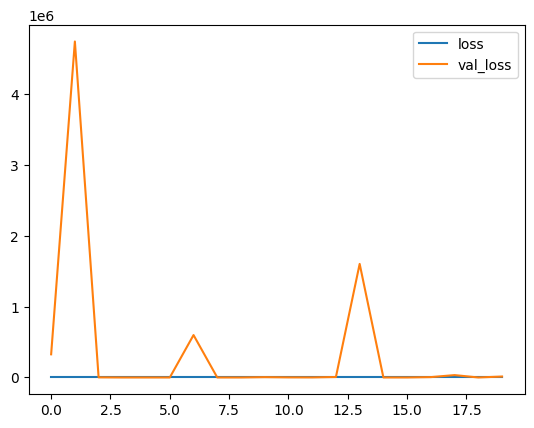

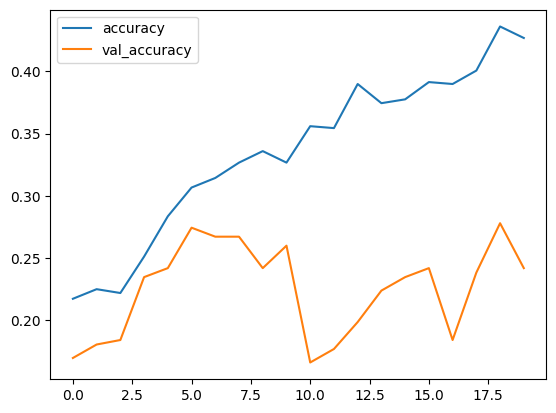

In [28]:
history_df_vgg16[['loss', 'val_loss']].plot()
history_df_vgg16[['accuracy', 'val_accuracy']].plot()

Text(50.5815972222222, 0.5, 'Valores Reales')

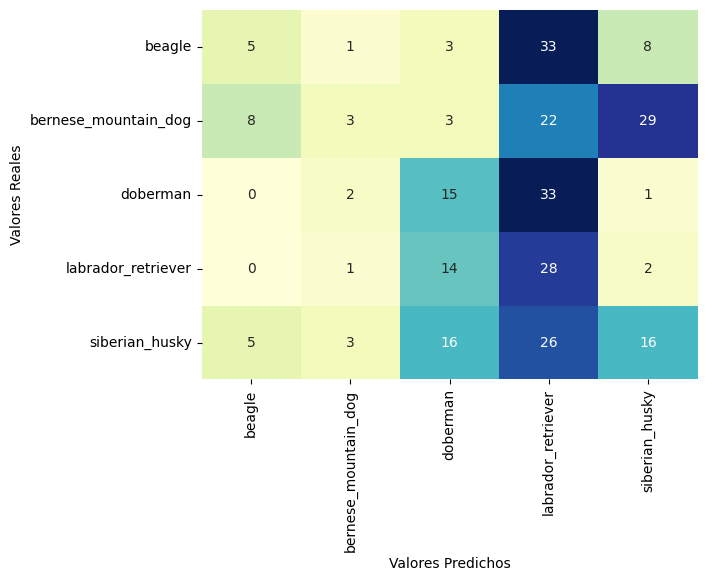

In [29]:
y_pred_vgg16 = model_vgg16.predict(test)
predicted_class_vgg16 = np.argmax(y_pred_vgg16, axis=1)

cm = confusion_matrix(actual_class, predicted_class_vgg16)

cm_df = pd.DataFrame(
    cm,
    index=breeds,
    columns=breeds
)

sns.heatmap(cm_df, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
plt.xlabel('Valores Predichos')
plt.ylabel('Valores Reales')